# Week10b - 8주차 머신러닝 실습

### 실습 1. 데이더 불러오기

            Close/Last    Volume     Open      High     Low
Date                                                       
2014-11-07       75.60  20757430   75.390   75.8550   75.02
2014-11-10       75.00  21526460   75.360   75.4799   74.61
2014-11-11       74.61  18702040   74.950   74.9800   74.03
2014-11-12       74.72  26497580   74.280   75.1400   73.54
2014-11-13       74.25  26408940   74.740   75.2400   73.64
...                ...       ...      ...       ...     ...
2024-10-30      591.80  26864930  600.980  601.2000  589.38
2024-10-31      567.58  26838400  585.000  589.9000  563.01
2024-11-01      567.16  15303240  567.605  573.6700  562.56
2024-11-04      560.68  12064600  564.100  568.6900  557.89
2024-11-05      572.43   9775379  567.305  573.4800  566.67

[2515 rows x 5 columns]


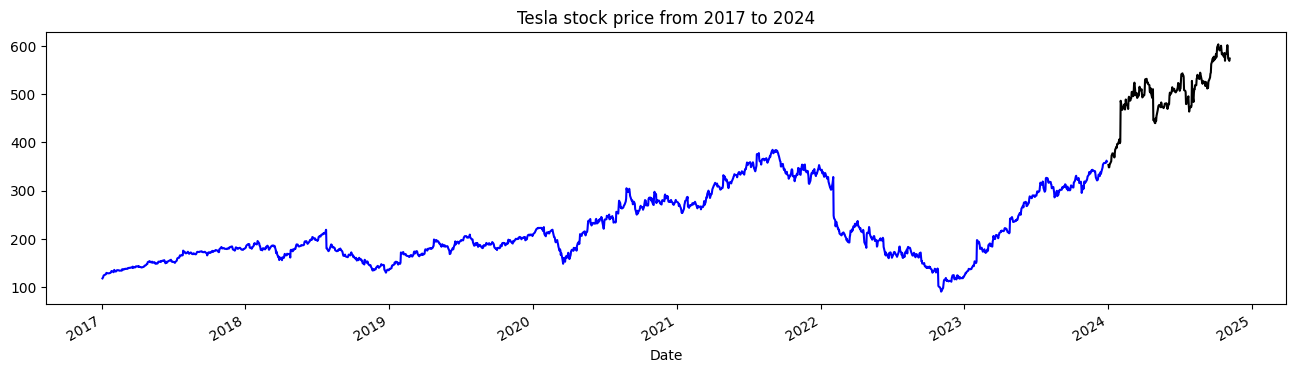

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, InputLayer

directory = "./csv"
dataset = pd.read_csv(directory + "\\" + "HistoricalData_meta.csv", index_col="Date", parse_dates=["Date"])

dataset = dataset.sort_index(ascending=True)#인덱스를 오름차순으로 정렬하여 시간 순으로 데이터가 배열
dataset['Close/Last'] = dataset['Close/Last'].replace('[\$,]', '', regex=True).astype(float)#$와 , 제거
dataset['Open'] = dataset['Open'].replace('[\$,]', '', regex=True).astype(float)
dataset['High'] = dataset['High'].replace('[\$,]', '', regex=True).astype(float)
dataset['Low'] = dataset['Low'].replace('[\$,]', '', regex=True).astype(float)
print(dataset)

tstart = 2017
tend = 2023
dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4),c='blue', legend=False)#2017-2023 High(주가 고점)데이터를 가지고 와서 파랑색 표시 
dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), c='black',legend=False)#2024 High(주가 고점)데이터를 가지고 와서 검정색 표시
plt.title("Tesla stock price from 2017 to 2024")
plt.show()

x_train = dataset.loc[f"{tstart}":f"{tend}", "High"].values #Train data로 2023 - 2024 data
original_test = dataset.loc[f"{tend+1}":, "High"].values # Test data로 2024년 이후 data
scaler = MinMaxScaler(feature_range=(0, 1))#MinMaxScaler 정규화 설정
x_train_norm = x_train.reshape(-1, 1)#2차원 배열로 변환하여 스케일러에 적합한 형식으로 만듦
x_train_scaled = scaler.fit_transform(x_train_norm)#MinMaxScaler 정규화 적용(0~1로 데이터 변환)

### 실습 2. 학습 데이터 추출 코드

In [3]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps # 61 
        if end_ix > len(sequence) - 1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]#seq_x 과거의 data(1~60) , seq_y(61): 예측 할 값
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

timesteps = 60 # 과거 60일간 주가
features = 1 # 주가변동 데이터-특징벡터 1개
X_train, y_train = split_sequence(x_train_scaled, timesteps)

### 실습 3. LSTM 모델 구축

In [ ]:
model_lstm = Sequential()#순차적으로 레이어를 쌓아 올리는 모델 구축 방법
model_lstm.add(InputLayer(input_shape=(timesteps,features)))#input_shape(timesteps, features):
model_lstm.add(LSTM(units=125,activation="tanh",return_sequences=True))#return_sequences=True를 통해 모든 타임 스텝에서 출력값이 다음 LSTM 모델로 넘어감
model_lstm.add(LSTM(units=64,activation="tanh"))#return_sequences 옵션이 없으므로 마지막 스텝에서 출력값만 반환
model_lstm.add(Dense(units=1))#Dense 는 linear

model_lstm.compile(optimizer="RMSprop", loss="mse")
model_lstm.summary()
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 125)           63500     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                48640     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 112,205
Trainable params: 112,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
54/54 [==============================] - 10s 80ms/step - loss: 0.0157
Epoch 2/50
54/54 [==============================] - 5s 84ms/step - loss: 0.0046
Epoch 3/50
54/54 [==============================] - 5s 87ms/step - loss: 0.0034
Epoch 4/50
54/54 [==============================] - 5s 89ms/step - loss: 0.0029
Epoch 5/50
54/54 [==============================] - 5s 95ms

### 실습 4. LSTM 모델 예측 코드

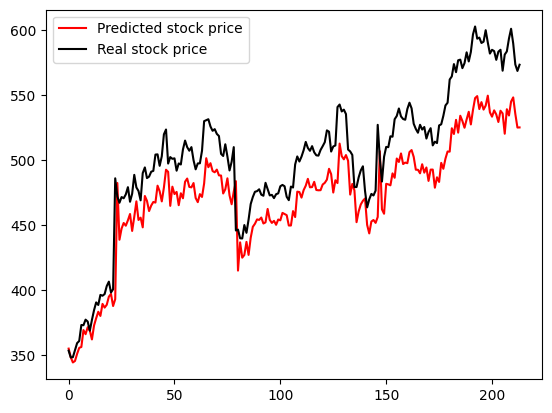

In [6]:
# 예측 
dataset_total = dataset.loc[:,"High"]
x_test = dataset_total[len(dataset_total) - len(original_test) - timesteps :].values #테스트 데이터 예측을 위해 필요한 과거 60일치 데이터와 테스트 데이터를 함께 가져오는 코드
x_test_norm = x_test.reshape(-1, 1)
x_test_scaled = scaler.transform(x_test_norm)

X_test, y_test = split_sequence(x_test_scaled, timesteps)
predicted_stock_price = model_lstm.predict(X_test)#학습 된 lstm 모델을 사용하여 주가 예측
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)#예측된 주가 데이터를 원래 스케일로 복원

plt.figure()
plt.plot(predicted_stock_price,c='red', label='Predicted stock price')
plt.plot(original_test,c='black',label='Real stock price')
plt.legend()
plt.show()